In [3]:
import polars as pl
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pl.read_csv('/Users/abhishekshah/Desktop/customer_analysis/twcs/twcs.csv')
except FileNotFoundError:
    print("Error: twcs.csv not found. Please make sure the file is in the correct directory.")
    exit()


In [5]:
import re
import string
import polars as pl

def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # 1. Remove URLs as they don't add semantic value
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # 2. Preserve company names in mentions by keeping the username after @
    # First replace @ with "mention:" as a marker
    text = re.sub(r'@(\w+)', r'mention:\1', text)
    
    # 3. Remove hashtags as symbols but keep the text
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # 4. Remove RT tag often found in retweets
    text = re.sub(r'^RT\s+', '', text)
    
    # 5. Remove HTML entities
    text = re.sub(r'&\w+;', '', text)
    
    # 6. Remove emojis
    emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F700-\U0001F77F"  # alchemical symbols
                              u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                              "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # 7. Keep apostrophes (') for contractions but remove other punctuation
    text = re.sub(r'[^\w\s\']', ' ', text)
    
    # 8. Convert to lowercase
    text = text.lower()
    
    # 9. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 10. Replace our "mention:" marker back with @ for brand identification
    text = text.replace('mention:', '@')
    
    return text

# Apply the improved cleaning function with explicit return_dtype
df = df.with_columns(
    pl.col('text').map_elements(clean_text, return_dtype=pl.Utf8).alias('clean_text')
)

# Example showing before and after
if len(df) > 0:
    sample = df.select(['text', 'clean_text']).sample(10)
    print("Text Cleaning Examples:")
    print(sample)
    
    # Check if our cleaning preserves company mentions
    mention_examples = df.filter(pl.col('text').str.contains('@'))
    if len(mention_examples) > 0:
        print("\nExamples with mentions preserved:")
        print(mention_examples.select(['text', 'clean_text']).sample(5))


Text Cleaning Examples:
shape: (10, 2)
┌─────────────────────────────────┬─────────────────────────────────┐
│ text                            ┆ clean_text                      │
│ ---                             ┆ ---                             │
│ str                             ┆ str                             │
╞═════════════════════════════════╪═════════════════════════════════╡
│ @161999 Our apologies. We are … ┆ mention 161999 our apologies w… │
│ @McDonalds what did you send I… ┆ mention mcdonalds what did you… │
│ I tried eating a single taco f… ┆ i tried eating a single taco f… │
│ @791251 Good afternoon, could … ┆ mention 791251 good afternoon … │
│ @TMobileHelp you have cost me … ┆ mention tmobilehelp you have c… │
│ @134193 @116447 Team @116447 w… ┆ mention 134193 mention 116447 … │
│ @678554 Do you remember what t… ┆ mention 678554 do you remember… │
│ @AskLyft how come so many of y… ┆ mention asklyft how come so ma… │
│ @737428 If you have a moment, … ┆ mention 737428 

In [7]:
df.columns

['tweet_id',
 'author_id',
 'inbound',
 'created_at',
 'text',
 'response_tweet_id',
 'in_response_to_tweet_id',
 'clean_text']

In [8]:
df['clean_text'].describe()

statistic,value
str,str
"""count""","""2811774"""
"""null_count""","""0"""
"""min""",""""""
"""max""","""ﾟεﾟ ﾑﾑﾑ 変なﾒｯｾｰｼﾞがきた アマゾン 一瞬ドキッ…"


In [11]:
import polars as pl
import re

# Sample a small number of tweets
TEST_SAMPLE_SIZE = 10
test_df = df.filter(pl.col('clean_text').is_not_null() & 
                  (pl.col('clean_text') != '')).sample(TEST_SAMPLE_SIZE)

print(f"Testing {TEST_SAMPLE_SIZE} sample tweets for embedding compatibility:")
print("-" * 70)

# Check each tweet
for i, row in enumerate(test_df.iter_rows(named=True)):
    text = row['clean_text']
    author = row['author_id']
    inbound = row['inbound'] 
    
    # Simple validation
    is_valid = isinstance(text, str) and len(text.strip()) > 0 and len(text) < 8000
    
    # Format output
    text_preview = text[:40] + "..." if len(text) > 40 else text
    user_type = "Customer" if inbound else "Company"
    
    print(f"{i+1}. {user_type} tweet by @{author}")
    print(f"   Text: {text_preview}")
    print(f"   Valid for embedding: {'✓' if is_valid else '✗'}")
    
    if not is_valid:
        if not isinstance(text, str):
            print("   Issue: Not a string")
        elif len(text.strip()) == 0:
            print("   Issue: Empty text")
        elif len(text) >= 8000:
            print("   Issue: Text too long")
    print()

# Quick summary
print("-" * 70)
print(f"Tweet Statistics:")
print(f"- Company tweets: {test_df.filter(~pl.col('inbound')).height}")
print(f"- Customer tweets: {test_df.filter(pl.col('inbound')).height}")

lengths = [len(t) if isinstance(t, str) else 0 for t in test_df['clean_text']]
print(f"- Average length: {sum(lengths)/len(lengths):.1f} characters")

Testing 10 sample tweets for embedding compatibility:
----------------------------------------------------------------------
1. Customer tweet by @638155
   Text: bruh i just need mention 115858 to fix t...
   Valid for embedding: ✓

2. Customer tweet by @795739
   Text: mention 796460 mention 59757 mention 795...
   Valid for embedding: ✓

3. Company tweet by @Ask_Spectrum
   Text: mention 142873 i am sorry you are having...
   Valid for embedding: ✓

4. Customer tweet by @701112
   Text: mention americanair has decided to take ...
   Valid for embedding: ✓

5. Customer tweet by @342515
   Text: mention jetblue however i just called th...
   Valid for embedding: ✓

6. Company tweet by @AirAsiaSupport
   Text: mention 166999 not allowed thanks for yo...
   Valid for embedding: ✓

7. Company tweet by @BofA_Help
   Text: mention 673697 pls click below send your...
   Valid for embedding: ✓

8. Customer tweet by @274412
   Text: mention gwrhelp pewsey
   Valid for embedding: ✓

9. Custome

In [16]:
import os
from dotenv import load_dotenv

import google.generativeai as genai

# Load environment variables
load_dotenv()

# Configure the Gemini client
api_key = os.getenv("GEMINI_API_KEY")
if not api_key:
    print("Error: GEMINI_API_KEY not found in environment variables.")
    exit()
genai.configure(api_key=api_key)

# Test the Gemini API
model = genai.GenerativeModel('gemini-2.0-flash')
try:
    response = model.generate_content("What is the capital of France?")
    print(response.text)
except Exception as e:
    print(f"Error: {e}")

The capital of France is **Paris**.



In [19]:
import os
import numpy as np
import polars as pl
import pickle
import time
import matplotlib.pyplot as plt
import google.generativeai as genai
from dotenv import load_dotenv
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Load environment variables
load_dotenv()

# Initialize the Gemini client
api_key = os.getenv("GEMINI_API_KEY") 
genai.configure(api_key=api_key)

# Optimized Gemini Embedding parameters for a smaller, single run (reduced tokens)
BATCH_SIZE = 40     # Items per request
RPM_LIMIT = 1200    # Requests per minute (Conservative)
MAX_BATCHES = 50    # Reduced batches for smaller run
MAX_TWEETS = BATCH_SIZE * MAX_BATCHES # Total texts to process
EMBEDDING_FILE = 'tweet_embeddings_small_run.pkl'

print(f"Optimized rate-limited embedding plan for a smaller, single run:")
print(f"- Processing {MAX_TWEETS} tweets in {MAX_BATCHES} batches in a single run")
print(f"- Each batch contains {BATCH_SIZE} tweets")
print(f"- Will respect a very conservative {RPM_LIMIT} requests per minute limit")
print(f"- Estimated runtime: {MAX_BATCHES/(RPM_LIMIT/60):.2f} minutes minimum\n")

# Sample tweets for embedding - use clean_text field
print(f"Sampling {MAX_TWEETS} tweets for embedding analysis...")
df_to_embed = df.filter(pl.col('clean_text').is_not_null() & (pl.col('clean_text') != '')).sample(MAX_TWEETS, seed=42)
texts = df_to_embed['clean_text'].to_list()

# Updated function to get embeddings with correct API usage
def get_embedding(text):
    """Get embedding for a single text"""
    try:
        # Fixed API call for embedding
        result = genai.embed_content(
            model="models/text-embedding-004",
            content=text,
            task_type="retrieval_document"
        )
        return result["embedding"]
    except Exception as e:
        print(f"Error: {e}")
        return None

# Process embeddings with rate limiting
print("Generating embeddings...")
all_embeddings = []
valid_texts = []
valid_indices = []
processed_count = 0
batch_times = []

# Create a simple progress indicator
total_batches = min(len(texts) // BATCH_SIZE + (1 if len(texts) % BATCH_SIZE > 0 else 0), MAX_BATCHES)
print(f"0/{total_batches} batches processed (0%)")

# Loop through texts with rate limiting
for batch_idx in range(total_batches):
    batch_start_time = time.time()
    
    # Get the current batch indices
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, len(texts))
    
    # Process current batch
    batch = texts[start_idx:end_idx]
    batch_embeddings = []
    batch_valid_indices = []
    batch_valid_texts = []
    
    for j, text in enumerate(batch):
        if isinstance(text, str) and len(text.strip()) > 0:
            embedding = get_embedding(text)
            if embedding is not None:
                batch_embeddings.append(embedding)
                batch_valid_texts.append(text)
                batch_valid_indices.append(start_idx+j)
            processed_count += 1
    
    # Add to our collection
    all_embeddings.extend(batch_embeddings)
    valid_texts.extend(batch_valid_texts)
    valid_indices.extend(batch_valid_indices)
    
    # Save progress after each batch
    with open(EMBEDDING_FILE, 'wb') as f:
        pickle.dump({
            'embeddings': all_embeddings, 
            'texts': valid_texts,
            'indices': valid_indices
        }, f)
    
    # Calculate batch processing time and track it
    elapsed = time.time() - batch_start_time
    batch_times.append(elapsed)
    avg_batch_time = np.mean(batch_times)
    
    # Rate limiting - only if needed
    requests_per_sec = 1/avg_batch_time if avg_batch_time > 0 else 0
    if requests_per_sec > (RPM_LIMIT/60):  # If processing faster than our limit
        sleep_time = (1/(RPM_LIMIT/60)) - avg_batch_time
        if sleep_time > 0:
            print(f"Rate limiting: sleeping for {sleep_time:.2f} seconds")
            time.sleep(sleep_time)
    
    # Simple progress update
    progress_pct = (batch_idx + 1) / total_batches * 100
    if batch_idx % 5 == 0 or batch_idx == total_batches - 1:
        print(f"{batch_idx+1}/{total_batches} batches processed ({progress_pct:.1f}%)")
        print(f"Processed {processed_count} tweets. Valid embeddings: {len(all_embeddings)}")
        if len(batch_times) > 1:
            print(f"Average batch processing time: {avg_batch_time:.2f} seconds")
            remaining_time = avg_batch_time * (total_batches - batch_idx - 1) / 60
            print(f"Estimated time remaining: {remaining_time:.2f} minutes")
        print("-" * 40)

# Final save
print(f"Embedding complete. Total valid embeddings: {len(all_embeddings)}")

Optimized rate-limited embedding plan for a smaller, single run:
- Processing 2000 tweets in 50 batches in a single run
- Each batch contains 40 tweets
- Will respect a very conservative 1200 requests per minute limit
- Estimated runtime: 2.50 minutes minimum

Sampling 2000 tweets for embedding analysis...
Generating embeddings...
0/50 batches processed (0%)
1/50 batches processed (2.0%)
Processed 40 tweets. Valid embeddings: 40
----------------------------------------
6/50 batches processed (12.0%)
Processed 240 tweets. Valid embeddings: 240
Average batch processing time: 8.94 seconds
Estimated time remaining: 6.55 minutes
----------------------------------------
11/50 batches processed (22.0%)
Processed 440 tweets. Valid embeddings: 440
Average batch processing time: 8.83 seconds
Estimated time remaining: 5.74 minutes
----------------------------------------
16/50 batches processed (32.0%)
Processed 640 tweets. Valid embeddings: 640
Average batch processing time: 8.72 seconds
Estimat

In [20]:
import os
import numpy as np
import polars as pl
import pickle
import time
import matplotlib.pyplot as plt
import google.generativeai as genai
from dotenv import load_dotenv
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Load environment variables
load_dotenv()

# Initialize the Gemini client
api_key = os.getenv("GEMINI_API_KEY") 
genai.configure(api_key=api_key)

# Embedding parameters - BATCH 2
BATCH_SIZE = 40              # Items per request
RPM_LIMIT = 1200             # Requests per minute
MAX_BATCHES = 50             # Number of batches
MAX_TWEETS = BATCH_SIZE * MAX_BATCHES  # Total tweets
EMBEDDING_FILE = 'tweet_embeddings_batch2.pkl'  # New file for second batch
BATCH_NUM = 2                # Batch identifier
START_INDEX = 2000           # Skip first 2000 already processed tweets

print(f"Embedding batch #{BATCH_NUM} configuration:")
print(f"- Processing {MAX_TWEETS} tweets in {MAX_BATCHES} batches")
print(f"- Each batch contains {BATCH_SIZE} tweets")
print(f"- Starting from index {START_INDEX}")
print(f"- Output file: {EMBEDDING_FILE}")
print(f"- Estimated runtime: {MAX_BATCHES/(RPM_LIMIT/60):.2f} minutes minimum\n")

# Sample tweets for embedding - STARTING AFTER PREVIOUS BATCH
print(f"Sampling {MAX_TWEETS} tweets for embedding analysis (starting from index {START_INDEX})...")
# Get all valid tweets
all_valid_tweets = df.filter(pl.col('clean_text').is_not_null() & (pl.col('clean_text') != ''))
# Sample tweets, ensuring we skip the first batch
df_to_embed = all_valid_tweets.sample(MAX_TWEETS + START_INDEX, seed=43)[START_INDEX:START_INDEX + MAX_TWEETS]
texts = df_to_embed['clean_text'].to_list()

# Function to get embeddings with correct API usage
def get_embedding(text):
    """Get embedding for a single text"""
    try:
        # Fixed API call for embedding
        result = genai.embed_content(
            model="models/text-embedding-004",
            content=text,
            task_type="retrieval_document"
        )
        return result["embedding"]
    except Exception as e:
        print(f"Error: {e}")
        return None

# Check if we need to resume from an existing file
all_embeddings = []
valid_texts = []
valid_indices = []
processed_count = 0

if os.path.exists(EMBEDDING_FILE):
    try:
        print(f"Found existing embeddings file. Attempting to resume...")
        with open(EMBEDDING_FILE, 'rb') as f:
            saved_data = pickle.load(f)
            all_embeddings = saved_data.get('embeddings', [])
            valid_texts = saved_data.get('texts', [])
            valid_indices = saved_data.get('indices', [])
            processed_count = len(all_embeddings)
        print(f"Successfully loaded {len(all_embeddings)} existing embeddings.")
        
        # Determine where to resume from
        if valid_indices:
            last_processed_idx = max(valid_indices) - START_INDEX + 1
            print(f"Resuming from position {last_processed_idx} in the current batch")
        else:
            last_processed_idx = 0
    except Exception as e:
        print(f"Error loading existing file: {e}")
        print("Starting fresh embedding process")
        last_processed_idx = 0
else:
    last_processed_idx = 0
    print("No existing file found. Starting fresh embedding process")

# Track batch processing times
batch_times = []

# Create a simple progress indicator
total_batches = min(len(texts) // BATCH_SIZE + (1 if len(texts) % BATCH_SIZE > 0 else 0), MAX_BATCHES)
current_batch = last_processed_idx // BATCH_SIZE
print(f"{current_batch}/{total_batches} batches already processed ({current_batch/total_batches*100:.1f}%)")

# Loop through texts with rate limiting
for batch_idx in range(current_batch, total_batches):
    batch_start_time = time.time()
    
    # Get the current batch indices
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, len(texts))
    
    # Process current batch
    batch = texts[start_idx:end_idx]
    batch_embeddings = []
    batch_valid_indices = []
    batch_valid_texts = []
    
    for j, text in enumerate(batch):
        if isinstance(text, str) and len(text.strip()) > 0:
            embedding = get_embedding(text)
            if embedding is not None:
                batch_embeddings.append(embedding)
                batch_valid_texts.append(text)
                # Store original index in the full dataset
                batch_valid_indices.append(START_INDEX + start_idx + j)
            processed_count += 1
    
    # Add to our collection
    all_embeddings.extend(batch_embeddings)
    valid_texts.extend(batch_valid_texts)
    valid_indices.extend(batch_valid_indices)
    
    # Save progress after each batch
    with open(EMBEDDING_FILE, 'wb') as f:
        pickle.dump({
            'embeddings': all_embeddings, 
            'texts': valid_texts,
            'indices': valid_indices,
            'batch_num': BATCH_NUM,
            'start_index': START_INDEX
        }, f)
    
    # Calculate batch processing time and track it
    elapsed = time.time() - batch_start_time
    batch_times.append(elapsed)
    avg_batch_time = np.mean(batch_times)
    
    # Rate limiting - only if needed
    requests_per_sec = 1/avg_batch_time if avg_batch_time > 0 else 0
    if requests_per_sec > (RPM_LIMIT/60):  # If processing faster than our limit
        sleep_time = (1/(RPM_LIMIT/60)) - avg_batch_time
        if sleep_time > 0:
            print(f"Rate limiting: sleeping for {sleep_time:.2f} seconds")
            time.sleep(sleep_time)
    
    # Simple progress update
    progress_pct = (batch_idx + 1) / total_batches * 100
    if batch_idx % 5 == 0 or batch_idx == total_batches - 1:
        print(f"Batch #{BATCH_NUM}: {batch_idx+1}/{total_batches} batches processed ({progress_pct:.1f}%)")
        print(f"Processed {processed_count} tweets. Valid embeddings: {len(all_embeddings)}")
        if len(batch_times) > 1:
            print(f"Average batch processing time: {avg_batch_time:.2f} seconds")
            remaining_time = avg_batch_time * (total_batches - batch_idx - 1) / 60
            print(f"Estimated time remaining: {remaining_time:.2f} minutes")
        print("-" * 40)

# Final save
print(f"Embedding batch #{BATCH_NUM} complete. Total valid embeddings: {len(all_embeddings)}")

Embedding batch #2 configuration:
- Processing 2000 tweets in 50 batches
- Each batch contains 40 tweets
- Starting from index 2000
- Output file: tweet_embeddings_batch2.pkl
- Estimated runtime: 2.50 minutes minimum

Sampling 2000 tweets for embedding analysis (starting from index 2000)...
No existing file found. Starting fresh embedding process
0/50 batches already processed (0.0%)
Batch #2: 1/50 batches processed (2.0%)
Processed 40 tweets. Valid embeddings: 40
----------------------------------------
Batch #2: 6/50 batches processed (12.0%)
Processed 240 tweets. Valid embeddings: 240
Average batch processing time: 7.97 seconds
Estimated time remaining: 5.85 minutes
----------------------------------------
Batch #2: 11/50 batches processed (22.0%)
Processed 440 tweets. Valid embeddings: 440
Average batch processing time: 7.96 seconds
Estimated time remaining: 5.17 minutes
----------------------------------------
Batch #2: 16/50 batches processed (32.0%)
Processed 640 tweets. Valid e

In [21]:
import os
import numpy as np
import polars as pl
import pickle
import time
import matplotlib.pyplot as plt
import google.generativeai as genai
from dotenv import load_dotenv
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Load environment variables
load_dotenv()

# Initialize the Gemini client
api_key = os.getenv("GEMINI_API_KEY") 
genai.configure(api_key=api_key)

# Embedding parameters - BATCH 3
BATCH_SIZE = 40              # Items per request
RPM_LIMIT = 1200             # Requests per minute
MAX_BATCHES = 50             # Number of batches
MAX_TWEETS = BATCH_SIZE * MAX_BATCHES  # Total tweets
EMBEDDING_FILE = 'tweet_embeddings_batch3.pkl'  # New file for third batch
BATCH_NUM = 3                # Batch identifier
START_INDEX = 4000           # Skip first 4000 already processed tweets

print(f"Embedding batch #{BATCH_NUM} configuration:")
print(f"- Processing {MAX_TWEETS} tweets in {MAX_BATCHES} batches")
print(f"- Each batch contains {BATCH_SIZE} tweets")
print(f"- Starting from index {START_INDEX}")
print(f"- Output file: {EMBEDDING_FILE}")
print(f"- Estimated runtime: {MAX_BATCHES/(RPM_LIMIT/60):.2f} minutes minimum\n")

# Sample tweets for embedding - STARTING AFTER PREVIOUS BATCH
print(f"Sampling {MAX_TWEETS} tweets for embedding analysis (starting from index {START_INDEX})...")
# Get all valid tweets
all_valid_tweets = df.filter(pl.col('clean_text').is_not_null() & (pl.col('clean_text') != ''))
# Sample tweets, ensuring we skip the first batch
df_to_embed = all_valid_tweets.sample(MAX_TWEETS + START_INDEX, seed=43)[START_INDEX:START_INDEX + MAX_TWEETS]
texts = df_to_embed['clean_text'].to_list()

# Function to get embeddings with correct API usage
def get_embedding(text):
    """Get embedding for a single text"""
    try:
        # Fixed API call for embedding
        result = genai.embed_content(
            model="models/text-embedding-004",
            content=text,
            task_type="retrieval_document"
        )
        return result["embedding"]
    except Exception as e:
        print(f"Error: {e}")
        return None

# Check if we need to resume from an existing file
all_embeddings = []
valid_texts = []
valid_indices = []
processed_count = 0

if os.path.exists(EMBEDDING_FILE):
    try:
        print(f"Found existing embeddings file. Attempting to resume...")
        with open(EMBEDDING_FILE, 'rb') as f:
            saved_data = pickle.load(f)
            all_embeddings = saved_data.get('embeddings', [])
            valid_texts = saved_data.get('texts', [])
            valid_indices = saved_data.get('indices', [])
            processed_count = len(all_embeddings)
        print(f"Successfully loaded {len(all_embeddings)} existing embeddings.")
        
        # Determine where to resume from
        if valid_indices:
            last_processed_idx = max(valid_indices) - START_INDEX + 1
            print(f"Resuming from position {last_processed_idx} in the current batch")
        else:
            last_processed_idx = 0
    except Exception as e:
        print(f"Error loading existing file: {e}")
        print("Starting fresh embedding process")
        last_processed_idx = 0
else:
    last_processed_idx = 0
    print("No existing file found. Starting fresh embedding process")

# Track batch processing times
batch_times = []

# Create a simple progress indicator
total_batches = min(len(texts) // BATCH_SIZE + (1 if len(texts) % BATCH_SIZE > 0 else 0), MAX_BATCHES)
current_batch = last_processed_idx // BATCH_SIZE
print(f"{current_batch}/{total_batches} batches already processed ({current_batch/total_batches*100:.1f}%)")

# Loop through texts with rate limiting
for batch_idx in range(current_batch, total_batches):
    batch_start_time = time.time()
    
    # Get the current batch indices
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, len(texts))
    
    # Process current batch
    batch = texts[start_idx:end_idx]
    batch_embeddings = []
    batch_valid_indices = []
    batch_valid_texts = []
    
    for j, text in enumerate(batch):
        if isinstance(text, str) and len(text.strip()) > 0:
            embedding = get_embedding(text)
            if embedding is not None:
                batch_embeddings.append(embedding)
                batch_valid_texts.append(text)
                # Store original index in the full dataset
                batch_valid_indices.append(START_INDEX + start_idx + j)
            processed_count += 1
    
    # Add to our collection
    all_embeddings.extend(batch_embeddings)
    valid_texts.extend(batch_valid_texts)
    valid_indices.extend(batch_valid_indices)
    
    # Save progress after each batch
    with open(EMBEDDING_FILE, 'wb') as f:
        pickle.dump({
            'embeddings': all_embeddings, 
            'texts': valid_texts,
            'indices': valid_indices,
            'batch_num': BATCH_NUM,
            'start_index': START_INDEX
        }, f)
    
    # Calculate batch processing time and track it
    elapsed = time.time() - batch_start_time
    batch_times.append(elapsed)
    avg_batch_time = np.mean(batch_times)
    
    # Rate limiting - only if needed
    requests_per_sec = 1/avg_batch_time if avg_batch_time > 0 else 0
    if requests_per_sec > (RPM_LIMIT/60):  # If processing faster than our limit
        sleep_time = (1/(RPM_LIMIT/60)) - avg_batch_time
        if sleep_time > 0:
            print(f"Rate limiting: sleeping for {sleep_time:.2f} seconds")
            time.sleep(sleep_time)
    
    # Simple progress update
    progress_pct = (batch_idx + 1) / total_batches * 100
    if batch_idx % 5 == 0 or batch_idx == total_batches - 1:
        print(f"Batch #{BATCH_NUM}: {batch_idx+1}/{total_batches} batches processed ({progress_pct:.1f}%)")
        print(f"Processed {processed_count} tweets. Valid embeddings: {len(all_embeddings)}")
        if len(batch_times) > 1:
            print(f"Average batch processing time: {avg_batch_time:.2f} seconds")
            remaining_time = avg_batch_time * (total_batches - batch_idx - 1) / 60
            print(f"Estimated time remaining: {remaining_time:.2f} minutes")
        print("-" * 40)

# Final save
print(f"Embedding batch #{BATCH_NUM} complete. Total valid embeddings: {len(all_embeddings)}")

Embedding batch #3 configuration:
- Processing 2000 tweets in 50 batches
- Each batch contains 40 tweets
- Starting from index 4000
- Output file: tweet_embeddings_batch3.pkl
- Estimated runtime: 2.50 minutes minimum

Sampling 2000 tweets for embedding analysis (starting from index 4000)...
No existing file found. Starting fresh embedding process
0/50 batches already processed (0.0%)
Batch #3: 1/50 batches processed (2.0%)
Processed 40 tweets. Valid embeddings: 40
----------------------------------------
Batch #3: 6/50 batches processed (12.0%)
Processed 240 tweets. Valid embeddings: 240
Average batch processing time: 8.05 seconds
Estimated time remaining: 5.90 minutes
----------------------------------------
Batch #3: 11/50 batches processed (22.0%)
Processed 440 tweets. Valid embeddings: 440
Average batch processing time: 7.95 seconds
Estimated time remaining: 5.17 minutes
----------------------------------------
Batch #3: 16/50 batches processed (32.0%)
Processed 640 tweets. Valid e

In [22]:
import os
import numpy as np
import polars as pl
import pickle
import time
import matplotlib.pyplot as plt
import google.generativeai as genai
from dotenv import load_dotenv
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Load environment variables
load_dotenv()

# Initialize the Gemini client
api_key = os.getenv("GEMINI_API_KEY") 
genai.configure(api_key=api_key)

# Embedding parameters - BATCH 2
BATCH_SIZE = 40              # Items per request
RPM_LIMIT = 1200             # Requests per minute
MAX_BATCHES = 50             # Number of batches
MAX_TWEETS = BATCH_SIZE * MAX_BATCHES  # Total tweets
EMBEDDING_FILE = 'tweet_embeddings_batch4.pkl'  # New file for second batch
BATCH_NUM = 4                # Batch identifier
START_INDEX = 6000           # Skip first 6000 already processed tweets

print(f"Embedding batch #{BATCH_NUM} configuration:")
print(f"- Processing {MAX_TWEETS} tweets in {MAX_BATCHES} batches")
print(f"- Each batch contains {BATCH_SIZE} tweets")
print(f"- Starting from index {START_INDEX}")
print(f"- Output file: {EMBEDDING_FILE}")
print(f"- Estimated runtime: {MAX_BATCHES/(RPM_LIMIT/60):.2f} minutes minimum\n")

# Sample tweets for embedding - STARTING AFTER PREVIOUS BATCH
print(f"Sampling {MAX_TWEETS} tweets for embedding analysis (starting from index {START_INDEX})...")
# Get all valid tweets
all_valid_tweets = df.filter(pl.col('clean_text').is_not_null() & (pl.col('clean_text') != ''))
# Sample tweets, ensuring we skip the first batch
df_to_embed = all_valid_tweets.sample(MAX_TWEETS + START_INDEX, seed=43)[START_INDEX:START_INDEX + MAX_TWEETS]
texts = df_to_embed['clean_text'].to_list()

# Function to get embeddings with correct API usage
def get_embedding(text):
    """Get embedding for a single text"""
    try:
        # Fixed API call for embedding
        result = genai.embed_content(
            model="models/text-embedding-004",
            content=text,
            task_type="retrieval_document"
        )
        return result["embedding"]
    except Exception as e:
        print(f"Error: {e}")
        return None

# Check if we need to resume from an existing file
all_embeddings = []
valid_texts = []
valid_indices = []
processed_count = 0

if os.path.exists(EMBEDDING_FILE):
    try:
        print(f"Found existing embeddings file. Attempting to resume...")
        with open(EMBEDDING_FILE, 'rb') as f:
            saved_data = pickle.load(f)
            all_embeddings = saved_data.get('embeddings', [])
            valid_texts = saved_data.get('texts', [])
            valid_indices = saved_data.get('indices', [])
            processed_count = len(all_embeddings)
        print(f"Successfully loaded {len(all_embeddings)} existing embeddings.")
        
        # Determine where to resume from
        if valid_indices:
            last_processed_idx = max(valid_indices) - START_INDEX + 1
            print(f"Resuming from position {last_processed_idx} in the current batch")
        else:
            last_processed_idx = 0
    except Exception as e:
        print(f"Error loading existing file: {e}")
        print("Starting fresh embedding process")
        last_processed_idx = 0
else:
    last_processed_idx = 0
    print("No existing file found. Starting fresh embedding process")

# Track batch processing times
batch_times = []

# Create a simple progress indicator
total_batches = min(len(texts) // BATCH_SIZE + (1 if len(texts) % BATCH_SIZE > 0 else 0), MAX_BATCHES)
current_batch = last_processed_idx // BATCH_SIZE
print(f"{current_batch}/{total_batches} batches already processed ({current_batch/total_batches*100:.1f}%)")

# Loop through texts with rate limiting
for batch_idx in range(current_batch, total_batches):
    batch_start_time = time.time()
    
    # Get the current batch indices
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, len(texts))
    
    # Process current batch
    batch = texts[start_idx:end_idx]
    batch_embeddings = []
    batch_valid_indices = []
    batch_valid_texts = []
    
    for j, text in enumerate(batch):
        if isinstance(text, str) and len(text.strip()) > 0:
            embedding = get_embedding(text)
            if embedding is not None:
                batch_embeddings.append(embedding)
                batch_valid_texts.append(text)
                # Store original index in the full dataset
                batch_valid_indices.append(START_INDEX + start_idx + j)
            processed_count += 1
    
    # Add to our collection
    all_embeddings.extend(batch_embeddings)
    valid_texts.extend(batch_valid_texts)
    valid_indices.extend(batch_valid_indices)
    
    # Save progress after each batch
    with open(EMBEDDING_FILE, 'wb') as f:
        pickle.dump({
            'embeddings': all_embeddings, 
            'texts': valid_texts,
            'indices': valid_indices,
            'batch_num': BATCH_NUM,
            'start_index': START_INDEX
        }, f)
    
    # Calculate batch processing time and track it
    elapsed = time.time() - batch_start_time
    batch_times.append(elapsed)
    avg_batch_time = np.mean(batch_times)
    
    # Rate limiting - only if needed
    requests_per_sec = 1/avg_batch_time if avg_batch_time > 0 else 0
    if requests_per_sec > (RPM_LIMIT/60):  # If processing faster than our limit
        sleep_time = (1/(RPM_LIMIT/60)) - avg_batch_time
        if sleep_time > 0:
            print(f"Rate limiting: sleeping for {sleep_time:.2f} seconds")
            time.sleep(sleep_time)
    
    # Simple progress update
    progress_pct = (batch_idx + 1) / total_batches * 100
    if batch_idx % 5 == 0 or batch_idx == total_batches - 1:
        print(f"Batch #{BATCH_NUM}: {batch_idx+1}/{total_batches} batches processed ({progress_pct:.1f}%)")
        print(f"Processed {processed_count} tweets. Valid embeddings: {len(all_embeddings)}")
        if len(batch_times) > 1:
            print(f"Average batch processing time: {avg_batch_time:.2f} seconds")
            remaining_time = avg_batch_time * (total_batches - batch_idx - 1) / 60
            print(f"Estimated time remaining: {remaining_time:.2f} minutes")
        print("-" * 40)

# Final save
print(f"Embedding batch #{BATCH_NUM} complete. Total valid embeddings: {len(all_embeddings)}")

Embedding batch #4 configuration:
- Processing 2000 tweets in 50 batches
- Each batch contains 40 tweets
- Starting from index 6000
- Output file: tweet_embeddings_batch4.pkl
- Estimated runtime: 2.50 minutes minimum

Sampling 2000 tweets for embedding analysis (starting from index 6000)...
No existing file found. Starting fresh embedding process
0/50 batches already processed (0.0%)
Batch #4: 1/50 batches processed (2.0%)
Processed 40 tweets. Valid embeddings: 40
----------------------------------------
Batch #4: 6/50 batches processed (12.0%)
Processed 240 tweets. Valid embeddings: 240
Average batch processing time: 7.96 seconds
Estimated time remaining: 5.84 minutes
----------------------------------------
Batch #4: 11/50 batches processed (22.0%)
Processed 440 tweets. Valid embeddings: 440
Average batch processing time: 7.92 seconds
Estimated time remaining: 5.15 minutes
----------------------------------------
Batch #4: 16/50 batches processed (32.0%)
Processed 640 tweets. Valid e

In [23]:
import os
import numpy as np
import polars as pl
import pickle
import time
import matplotlib.pyplot as plt
import google.generativeai as genai
from dotenv import load_dotenv
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Load environment variables
load_dotenv()

# Initialize the Gemini client
api_key = os.getenv("GEMINI_API_KEY") 
genai.configure(api_key=api_key)

# Embedding parameters - BATCH 2
BATCH_SIZE = 40              # Items per request
RPM_LIMIT = 1200             # Requests per minute
MAX_BATCHES = 50             # Number of batches
MAX_TWEETS = BATCH_SIZE * MAX_BATCHES  # Total tweets
EMBEDDING_FILE = 'tweet_embeddings_batch5.pkl'  # New file for second batch
BATCH_NUM = 5               # Batch identifier
START_INDEX = 8000           # Skip first 6000 already processed tweets

print(f"Embedding batch #{BATCH_NUM} configuration:")
print(f"- Processing {MAX_TWEETS} tweets in {MAX_BATCHES} batches")
print(f"- Each batch contains {BATCH_SIZE} tweets")
print(f"- Starting from index {START_INDEX}")
print(f"- Output file: {EMBEDDING_FILE}")
print(f"- Estimated runtime: {MAX_BATCHES/(RPM_LIMIT/60):.2f} minutes minimum\n")

# Sample tweets for embedding - STARTING AFTER PREVIOUS BATCH
print(f"Sampling {MAX_TWEETS} tweets for embedding analysis (starting from index {START_INDEX})...")
# Get all valid tweets
all_valid_tweets = df.filter(pl.col('clean_text').is_not_null() & (pl.col('clean_text') != ''))
# Sample tweets, ensuring we skip the first batch
df_to_embed = all_valid_tweets.sample(MAX_TWEETS + START_INDEX, seed=43)[START_INDEX:START_INDEX + MAX_TWEETS]
texts = df_to_embed['clean_text'].to_list()

# Function to get embeddings with correct API usage
def get_embedding(text):
    """Get embedding for a single text"""
    try:
        # Fixed API call for embedding
        result = genai.embed_content(
            model="models/text-embedding-004",
            content=text,
            task_type="retrieval_document"
        )
        return result["embedding"]
    except Exception as e:
        print(f"Error: {e}")
        return None

# Check if we need to resume from an existing file
all_embeddings = []
valid_texts = []
valid_indices = []
processed_count = 0

if os.path.exists(EMBEDDING_FILE):
    try:
        print(f"Found existing embeddings file. Attempting to resume...")
        with open(EMBEDDING_FILE, 'rb') as f:
            saved_data = pickle.load(f)
            all_embeddings = saved_data.get('embeddings', [])
            valid_texts = saved_data.get('texts', [])
            valid_indices = saved_data.get('indices', [])
            processed_count = len(all_embeddings)
        print(f"Successfully loaded {len(all_embeddings)} existing embeddings.")
        
        # Determine where to resume from
        if valid_indices:
            last_processed_idx = max(valid_indices) - START_INDEX + 1
            print(f"Resuming from position {last_processed_idx} in the current batch")
        else:
            last_processed_idx = 0
    except Exception as e:
        print(f"Error loading existing file: {e}")
        print("Starting fresh embedding process")
        last_processed_idx = 0
else:
    last_processed_idx = 0
    print("No existing file found. Starting fresh embedding process")

# Track batch processing times
batch_times = []

# Create a simple progress indicator
total_batches = min(len(texts) // BATCH_SIZE + (1 if len(texts) % BATCH_SIZE > 0 else 0), MAX_BATCHES)
current_batch = last_processed_idx // BATCH_SIZE
print(f"{current_batch}/{total_batches} batches already processed ({current_batch/total_batches*100:.1f}%)")

# Loop through texts with rate limiting
for batch_idx in range(current_batch, total_batches):
    batch_start_time = time.time()
    
    # Get the current batch indices
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, len(texts))
    
    # Process current batch
    batch = texts[start_idx:end_idx]
    batch_embeddings = []
    batch_valid_indices = []
    batch_valid_texts = []
    
    for j, text in enumerate(batch):
        if isinstance(text, str) and len(text.strip()) > 0:
            embedding = get_embedding(text)
            if embedding is not None:
                batch_embeddings.append(embedding)
                batch_valid_texts.append(text)
                # Store original index in the full dataset
                batch_valid_indices.append(START_INDEX + start_idx + j)
            processed_count += 1
    
    # Add to our collection
    all_embeddings.extend(batch_embeddings)
    valid_texts.extend(batch_valid_texts)
    valid_indices.extend(batch_valid_indices)
    
    # Save progress after each batch
    with open(EMBEDDING_FILE, 'wb') as f:
        pickle.dump({
            'embeddings': all_embeddings, 
            'texts': valid_texts,
            'indices': valid_indices,
            'batch_num': BATCH_NUM,
            'start_index': START_INDEX
        }, f)
    
    # Calculate batch processing time and track it
    elapsed = time.time() - batch_start_time
    batch_times.append(elapsed)
    avg_batch_time = np.mean(batch_times)
    
    # Rate limiting - only if needed
    requests_per_sec = 1/avg_batch_time if avg_batch_time > 0 else 0
    if requests_per_sec > (RPM_LIMIT/60):  # If processing faster than our limit
        sleep_time = (1/(RPM_LIMIT/60)) - avg_batch_time
        if sleep_time > 0:
            print(f"Rate limiting: sleeping for {sleep_time:.2f} seconds")
            time.sleep(sleep_time)
    
    # Simple progress update
    progress_pct = (batch_idx + 1) / total_batches * 100
    if batch_idx % 5 == 0 or batch_idx == total_batches - 1:
        print(f"Batch #{BATCH_NUM}: {batch_idx+1}/{total_batches} batches processed ({progress_pct:.1f}%)")
        print(f"Processed {processed_count} tweets. Valid embeddings: {len(all_embeddings)}")
        if len(batch_times) > 1:
            print(f"Average batch processing time: {avg_batch_time:.2f} seconds")
            remaining_time = avg_batch_time * (total_batches - batch_idx - 1) / 60
            print(f"Estimated time remaining: {remaining_time:.2f} minutes")
        print("-" * 40)

# Final save
print(f"Embedding batch #{BATCH_NUM} complete. Total valid embeddings: {len(all_embeddings)}")

Embedding batch #5 configuration:
- Processing 2000 tweets in 50 batches
- Each batch contains 40 tweets
- Starting from index 8000
- Output file: tweet_embeddings_batch5.pkl
- Estimated runtime: 2.50 minutes minimum

Sampling 2000 tweets for embedding analysis (starting from index 8000)...
No existing file found. Starting fresh embedding process
0/50 batches already processed (0.0%)
Batch #5: 1/50 batches processed (2.0%)
Processed 40 tweets. Valid embeddings: 40
----------------------------------------
Batch #5: 6/50 batches processed (12.0%)
Processed 240 tweets. Valid embeddings: 240
Average batch processing time: 8.01 seconds
Estimated time remaining: 5.87 minutes
----------------------------------------
Batch #5: 11/50 batches processed (22.0%)
Processed 440 tweets. Valid embeddings: 440
Average batch processing time: 7.95 seconds
Estimated time remaining: 5.17 minutes
----------------------------------------
Batch #5: 16/50 batches processed (32.0%)
Processed 640 tweets. Valid e

In [24]:
import os
import numpy as np
import pandas as pd
import polars as pl
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

# 1. Load and combine all embedding batches
print("Loading and combining embedding batches...")
embedding_files = [
    'tweet_embeddings_small_run.pkl',  # Batch 1
    'tweet_embeddings_batch2.pkl',     # Batch 2
    'tweet_embeddings_batch3.pkl',     # Batch 3
    'tweet_embeddings_batch4.pkl',     # Batch 4
    'tweet_embeddings_batch5.pkl'      # Batch 5
]

all_embeddings = []
all_texts = []
all_indices = []
batch_info = []

# Load all available batches
for i, file_path in enumerate(embedding_files):
    if os.path.exists(file_path):
        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                
            embeddings = data.get('embeddings', [])
            texts = data.get('texts', [])
            indices = data.get('indices', [])
            batch_num = data.get('batch_num', i+1)
            
            # Append batch data
            batch_size = len(embeddings)
            all_embeddings.extend(embeddings)
            all_texts.extend(texts)
            all_indices.extend(indices)
            batch_info.append({
                'batch_num': batch_num,
                'file': file_path,
                'size': batch_size
            })
            
            print(f"Loaded batch {batch_num} from {file_path}: {batch_size} embeddings")
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    else:
        print(f"File not found: {file_path}")

# Convert embeddings to numpy array
embeddings_array = np.array(all_embeddings)
print(f"Combined {len(all_embeddings)} embeddings from {len(batch_info)} batches")
print(f"Embedding dimensions: {embeddings_array.shape}")

Loading and combining embedding batches...
Loaded batch 1 from tweet_embeddings_small_run.pkl: 2000 embeddings
Loaded batch 2 from tweet_embeddings_batch2.pkl: 2000 embeddings
Loaded batch 3 from tweet_embeddings_batch3.pkl: 2000 embeddings
Loaded batch 4 from tweet_embeddings_batch4.pkl: 2000 embeddings
Loaded batch 5 from tweet_embeddings_batch5.pkl: 2000 embeddings
Combined 10000 embeddings from 5 batches
Embedding dimensions: (10000, 768)


In [ ]:
# 2. Save combined embeddings for future use
combined_path = 'combined_embeddings.pkl'
with open(combined_path, 'wb') as f:
    pickle.dump({
        'embeddings': all_embeddings,
        'texts': all_texts,
        'indices': all_indices,
        'batch_info': batch_info
    }, f)
print(f"Combined embeddings saved to {combined_path}")

Combined embeddings saved to combined_embeddings.pkl


In [26]:

# 3. Dimensionality reduction for visualization
print("\nReducing dimensions for visualization...")
# Use UMAP for better cluster separation (alternative to t-SNE)
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, 
                   min_dist=0.1, metric='cosine')
embeddings_2d = reducer.fit_transform(embeddings_array)


Reducing dimensions for visualization...


/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Finding optimal number of clusters...
  2 clusters: silhouette score = 0.0592
  3 clusters: silhouette score = 0.0617
  4 clusters: silhouette score = 0.0469
  5 clusters: silhouette score = 0.0364
  6 clusters: silhouette score = 0.0336
  7 clusters: silhouette score = 0.0452
  8 clusters: silhouette score = 0.0437
  9 clusters: silhouette score = 0.0402
  10 clusters: silhouette score = 0.0344
  11 clusters: silhouette score = 0.0381
  12 clusters: silhouette score = 0.0348
  13 clusters: silhouette score = 0.0361
  14 clusters: silhouette score = 0.0370
  15 clusters: silhouette score = 0.0410
  16 clusters: silhouette score = 0.0371
  17 clusters: silhouette score = 0.0346
  18 clusters: silhouette score = 0.0413
  19 clusters: silhouette score = 0.0322
  20 clusters: silhouette score = 0.0306


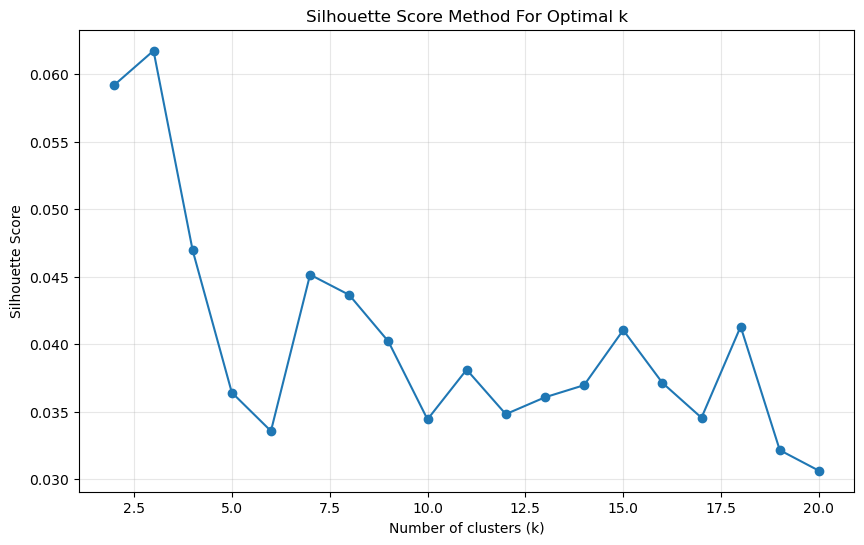


Optimal number of clusters: 3


In [27]:
# 4. Determine optimal number of clusters
max_clusters = 20
silhouette_scores = []

print("Finding optimal number of clusters...")
for n_clusters in range(2, max_clusters + 1):
    # Use spherical k-means for better results with embeddings
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(normalize(embeddings_array))
    
    # Calculate silhouette score
    try:
        score = silhouette_score(embeddings_array, clusters)
        silhouette_scores.append(score)
        print(f"  {n_clusters} clusters: silhouette score = {score:.4f}")
    except:
        silhouette_scores.append(0)
        print(f"  Error calculating silhouette score for {n_clusters} clusters")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, 'o-')
plt.title('Silhouette Score Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal number of clusters
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"\nOptimal number of clusters: {optimal_clusters}")

In [28]:
# 5. Final clustering with optimal cluster count
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)
clusters = kmeans.fit_predict(normalize(embeddings_array))

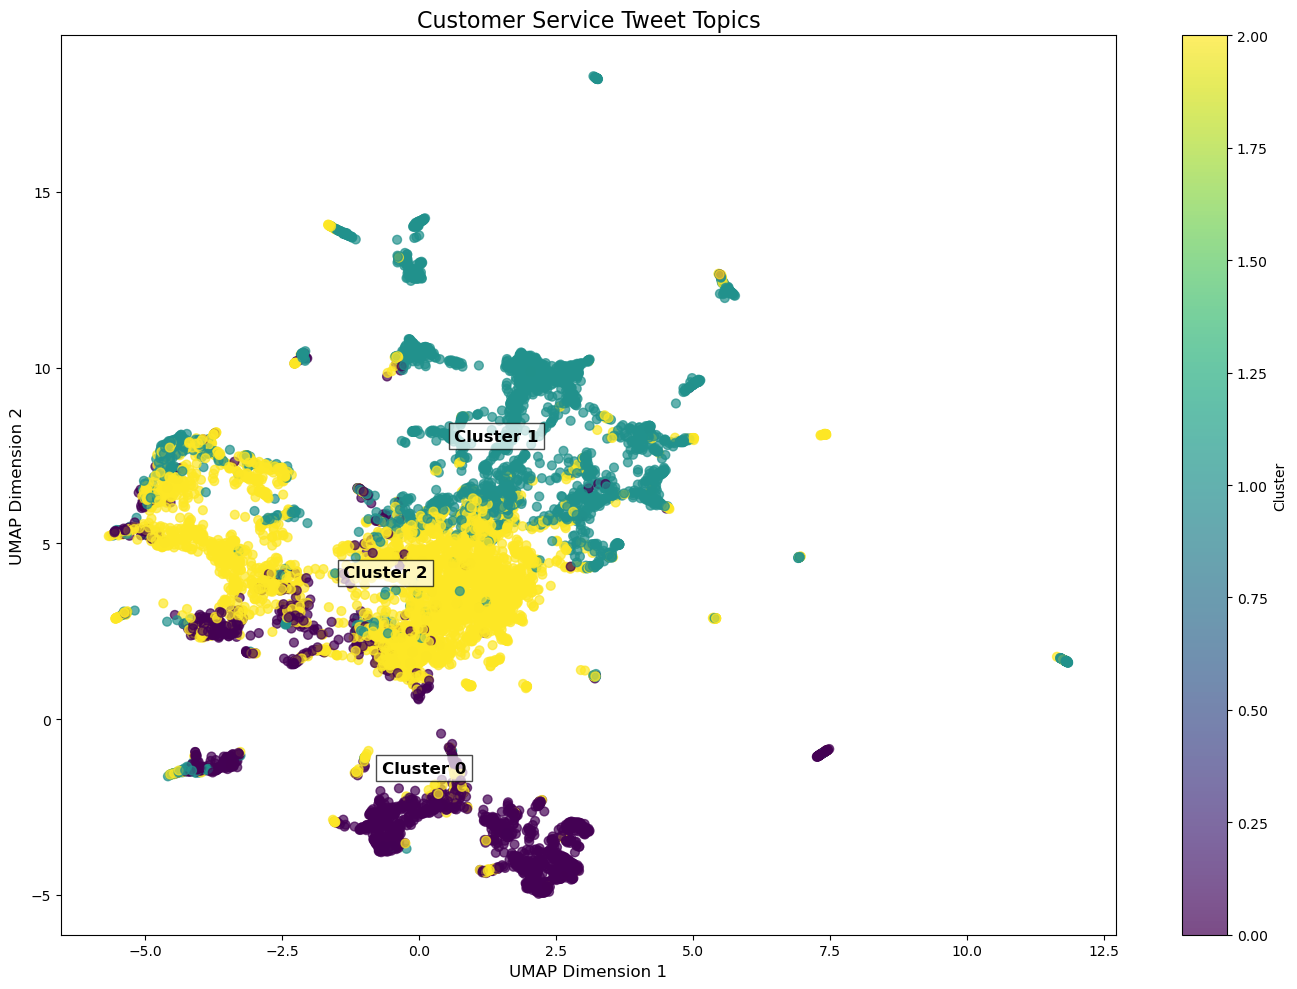

In [29]:
# 6. Visualize clusters
plt.figure(figsize=(14, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=clusters, cmap='viridis', alpha=0.7, s=40)
plt.colorbar(scatter, label='Cluster')
plt.title('Customer Service Tweet Topics', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)

# Add cluster labels and sample tweets
for cluster_id in range(optimal_clusters):
    # Get points in this cluster
    cluster_points = np.where(clusters == cluster_id)[0]
    
    if len(cluster_points) > 0:
        # Find center of cluster in 2D space for label positioning
        center_x = np.mean(embeddings_2d[cluster_points, 0])
        center_y = np.mean(embeddings_2d[cluster_points, 1])
        
        # Add cluster label at center
        plt.text(center_x, center_y, f"Cluster {cluster_id}", 
                fontsize=12, fontweight='bold', 
                ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('customer_service_clusters.png', dpi=300)
plt.show()

In [30]:

# 7. Analyze cluster content
print("\nAnalyzing cluster content...")
# Create a DataFrame for analysis
cluster_df = pd.DataFrame({
    'text': all_texts,
    'cluster': clusters,
    'index': all_indices,
})


Analyzing cluster content...


In [31]:

# Calculate cluster statistics
cluster_stats = cluster_df.groupby('cluster').agg({'text': 'count'}).reset_index()
cluster_stats.columns = ['cluster', 'tweet_count']
cluster_stats['percentage'] = cluster_stats['tweet_count'] / len(cluster_df) * 100

print("\nCluster statistics:")
print(cluster_stats)


Cluster statistics:
   cluster  tweet_count  percentage
0        0         2209       22.09
1        1         3335       33.35
2        2         4456       44.56


In [32]:

# Extract representative tweets from each cluster
print("\nRepresentative tweets from each cluster:")
for cluster_id in range(optimal_clusters):
    cluster_texts = cluster_df[cluster_df['cluster'] == cluster_id]['text'].tolist()
    
    if cluster_texts:
        print(f"\nCluster {cluster_id} ({len(cluster_texts)} tweets, {len(cluster_texts)/len(all_texts)*100:.1f}%):")
        
        # Print a few example tweets
        for text in cluster_texts[:5]:
            print(f"- {text[:100]}..." if len(text) > 100 else f"- {text}")
        
        # Save cluster tweets to file
        with open(f'cluster_{cluster_id}_tweets.txt', 'w') as f:
            for text in cluster_texts:
                f.write(f"{text}\n")
        
        print(f"Saved {len(cluster_texts)} tweets to cluster_{cluster_id}_tweets.txt")


Representative tweets from each cluster:

Cluster 0 (2209 tweets, 22.1%):
- mention americanair mention 189789 fuck outta here
- mention tacobellteam where on your website can i submit an inquiry feedback that doesn t have anythi...
- mention chipotletweets chipotle is my shit
- mention amazonhelp hang on a second have you not read the fact that i believe a 5 gift certificate i...
- mention virgintrains mention 314478 you don't say
Saved 2209 tweets to cluster_0_tweets.txt

Cluster 1 (3335 tweets, 33.4%):
- would not recommend an mention 118197 laptop to anyone has been nothing but problems had to return 3...
- mention 675003 hi billy i'd like to help please try these steps let me know how it goes senan
- mention amazonhelp see screenshot
- mention azuresupport i used recovery service container in japanwest region
- mention 314466 hi thanks for reaching out i'm happy to look into your internet connection concerns p...
Saved 3335 tweets to cluster_1_tweets.txt

Cluster 2 (4456 tweets, 

In [33]:
# 8. Save clustering results for future reference
cluster_data = {
    'embeddings_2d': embeddings_2d,
    'clusters': clusters,
    'texts': all_texts,
    'indices': all_indices,
    'optimal_clusters': optimal_clusters
}

with open('clustering_results.pkl', 'wb') as f:
    pickle.dump(cluster_data, f)

print("\nClustering analysis complete!")


Clustering analysis complete!


In [34]:
import os
import numpy as np
import pandas as pd
import polars as pl
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Load the clustering results
with open('clustering_results.pkl', 'rb') as f:
    cluster_data = pickle.load(f)

# Extract data
clusters = cluster_data['clusters']
indices = cluster_data['indices']
texts = cluster_data['texts']

# 1. Time-Based Analysis
print("Analyzing issue evolution over time...")

# Create a DataFrame with the cluster assignments
cluster_df = pd.DataFrame({
    'index': indices,
    'text': texts,
    'cluster': clusters
})

Analyzing issue evolution over time...


In [35]:
# Join with the original dataframe to get timestamps
# Convert to pandas first if needed
df_pd = df.to_pandas()

# Map indices back to original dataframe
analysis_df = pd.merge(
    cluster_df,
    df_pd[['tweet_id', 'created_at', 'author_id', 'inbound']],
    left_on='index',
    right_index=True,
    how='left'
)

In [36]:
# Ensure datetime format
analysis_df['created_at'] = pd.to_datetime(analysis_df['created_at'])

/var/folders/r6/b87zwk157sz4fy3q2qlsmrp00000gn/T/ipykernel_78559/715716046.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  analysis_df['created_at'] = pd.to_datetime(analysis_df['created_at'])


In [37]:
# Check a sample of the date formats
print("Sample date values:")
date_samples = analysis_df['created_at'].astype(str).sample(min(5, len(analysis_df))).tolist()
for sample in date_samples:
    print(f"- {sample}")

# Try to convert with explicit format
try:
    # Common Twitter API date format
    analysis_df['created_at'] = pd.to_datetime(analysis_df['created_at'], format='%Y-%m-%dT%H:%M:%S.%fZ')
    print("Successfully converted dates with format '%Y-%m-%dT%H:%M:%S.%fZ'")
except ValueError:
    try:
        # Alternative format
        analysis_df['created_at'] = pd.to_datetime(analysis_df['created_at'], format='%Y-%m-%d %H:%M:%S%z')
        print("Successfully converted dates with format '%Y-%m-%d %H:%M:%S%z'")
    except ValueError:
        # Fall back to dateutil parser but with errors='coerce' to handle problematic values
        print("Using flexible parser and handling invalid dates...")
        analysis_df['created_at'] = pd.to_datetime(analysis_df['created_at'], errors='coerce')
        
        # Check for and handle NaT values
        nat_count = analysis_df['created_at'].isna().sum()
        if nat_count > 0:
            print(f"Warning: {nat_count} date values couldn't be parsed and were set to NaT")
            # For analysis, we can drop or fill these values
            # analysis_df = analysis_df.dropna(subset=['created_at'])  # Option 1: Drop
            analysis_df['created_at'] = analysis_df['created_at'].fillna(pd.Timestamp('2022-01-01'))  # Option 2: Fill with default
            print(f"Filled invalid dates with default timestamp")

# Verify conversion was successful
print("\nDate range in dataset:")
print(f"- Earliest: {analysis_df['created_at'].min()}")
print(f"- Latest: {analysis_df['created_at'].max()}")
print(f"- Total timespan: {(analysis_df['created_at'].max() - analysis_df['created_at'].min()).days} days")

Sample date values:
- 2017-10-31 14:38:12+00:00
- 2017-11-01 02:08:26+00:00
- 2017-10-31 23:26:28+00:00
- 2017-11-18 00:59:33+00:00
- 2017-10-31 22:41:02+00:00
Successfully converted dates with format '%Y-%m-%dT%H:%M:%S.%fZ'

Date range in dataset:
- Earliest: 2011-08-29 03:20:05+00:00
- Latest: 2017-12-03 21:03:24+00:00
- Total timespan: 2288 days


In [38]:
# Group by week and cluster to track evolution over time
analysis_df['week'] = analysis_df['created_at'].dt.to_period('W')
issue_evolution = analysis_df.groupby(['week', 'cluster']).size().unstack().fillna(0)

/var/folders/r6/b87zwk157sz4fy3q2qlsmrp00000gn/T/ipykernel_78559/1188593992.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  analysis_df['week'] = analysis_df['created_at'].dt.to_period('W')


Visualizing issue evolution from 2017-08-07/2017-08-13 to 2017-11-27/2017-12-03
Number of weeks: 14


<Figure size 1600x800 with 0 Axes>

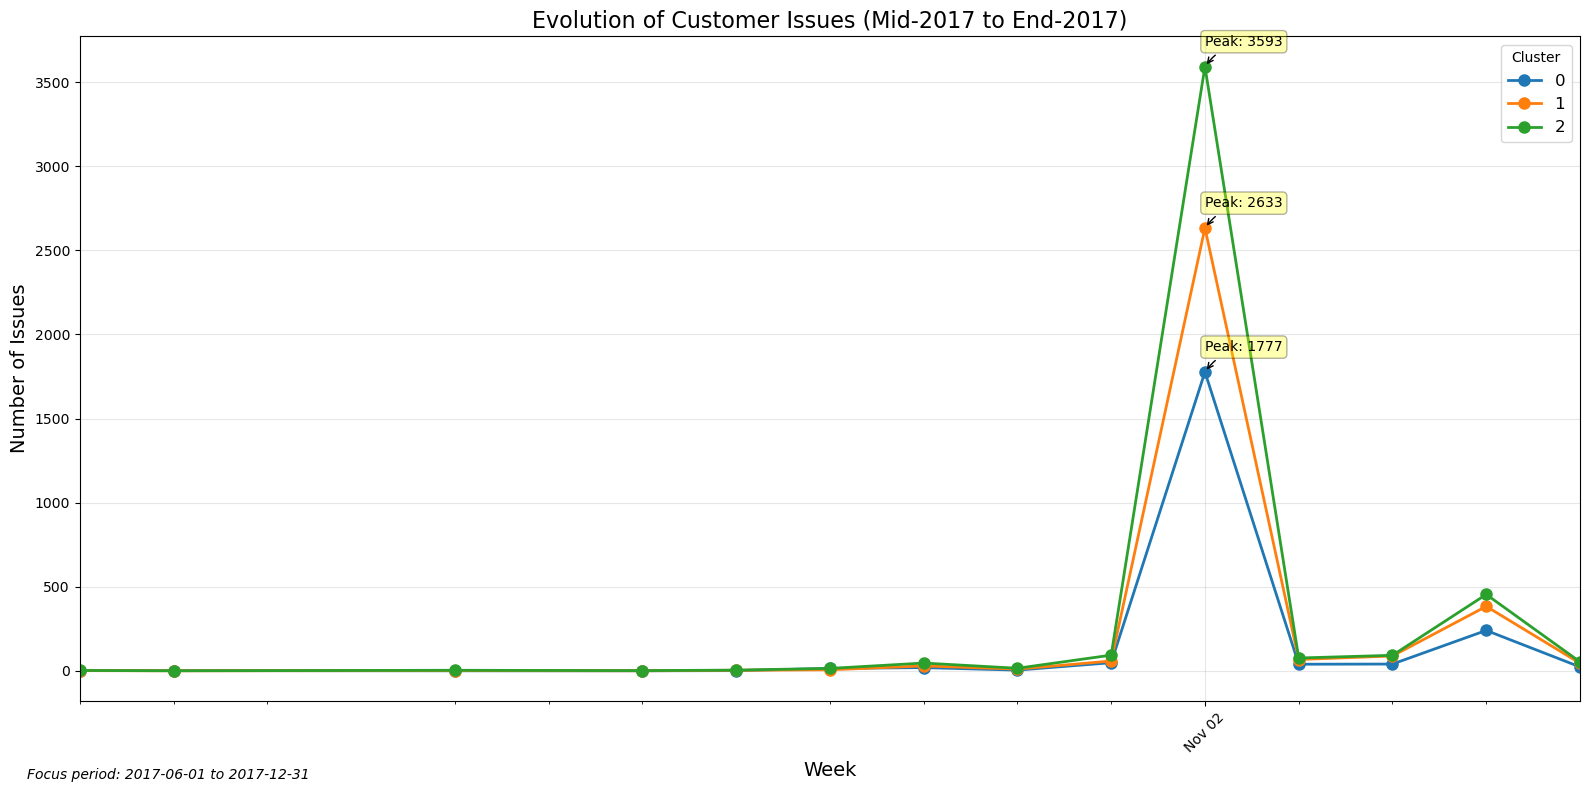

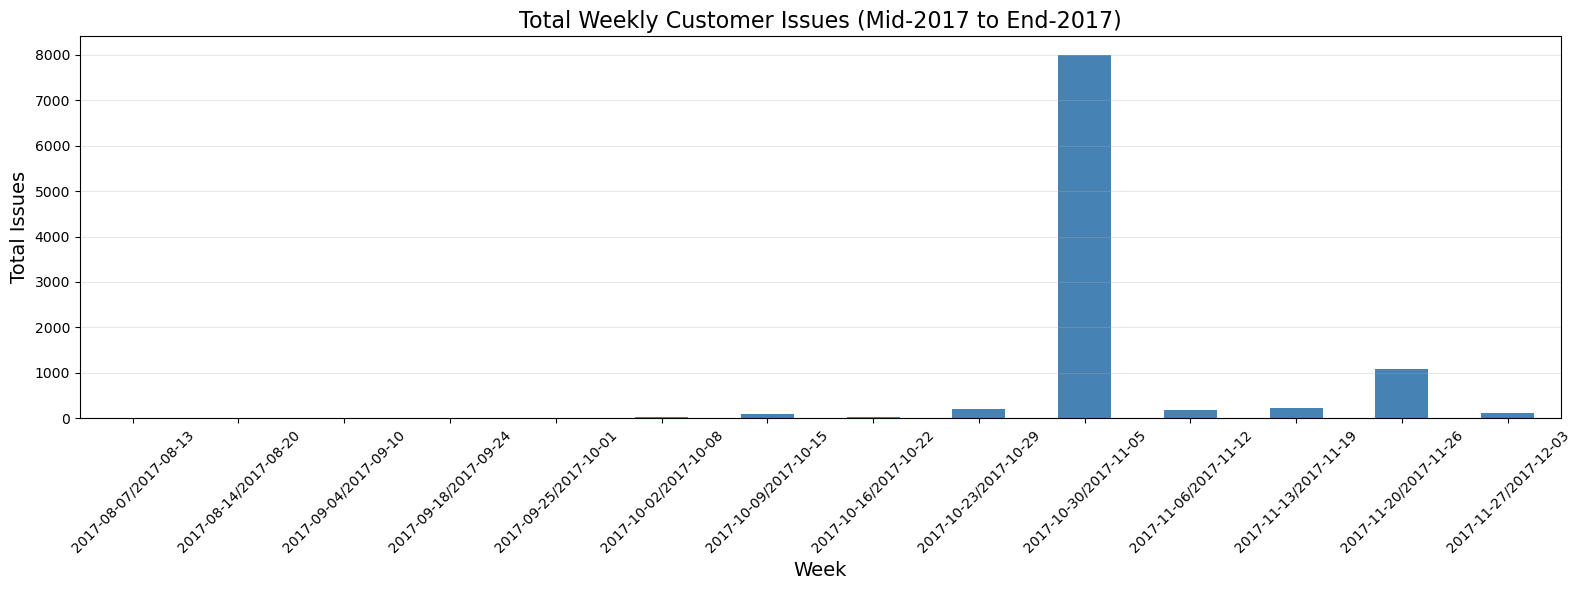

In [40]:
# Filter data for mid-2017 onwards
start_date = '2017-06-01'  # Mid-2017 starting point
end_date = '2017-12-31'    # End of 2017

# Filter the issue_evolution DataFrame to only include dates after mid-2017
filtered_evolution = issue_evolution[issue_evolution.index >= start_date]

# Print data range being visualized
print(f"Visualizing issue evolution from {filtered_evolution.index.min()} to {filtered_evolution.index.max()}")
print(f"Number of weeks: {len(filtered_evolution)}")

# Plot issue evolution over time with the filtered data
plt.figure(figsize=(16, 8))
filtered_evolution.plot(figsize=(16, 8), kind='line', marker='o', linewidth=2, markersize=8)
plt.title('Evolution of Customer Issues (Mid-2017 to End-2017)', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Number of Issues', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Improve x-axis labels for better readability
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.WeekdayLocator(interval=2))

# Add a subtle highlight for important trends
max_values = filtered_evolution.idxmax()
for cluster, week in max_values.items():
    if pd.notnull(week):  # Check if there's a valid maximum
        max_value = filtered_evolution.loc[week, cluster]
        plt.annotate(f'Peak: {int(max_value)}',
                    xy=(week, max_value),
                    xytext=(0, 15),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
                    fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3))

# Add a note about the time period focus
plt.figtext(0.02, 0.02, f"Focus period: {start_date} to {end_date}", 
           fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('issue_evolution_mid_2017.png', dpi=300)
plt.show()

# Optional: Show weekly totals across all clusters
weekly_totals = filtered_evolution.sum(axis=1)
plt.figure(figsize=(16, 6))
weekly_totals.plot(kind='bar', color='steelblue')
plt.title('Total Weekly Customer Issues (Mid-2017 to End-2017)', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Total Issues', fontsize=14)
plt.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('weekly_totals_mid_2017.png', dpi=300)
plt.show()

In [41]:
# 2. Escalation Prediction Model
print("\nDeveloping escalation prediction model...")

# Define features that might indicate escalation
# - Response time (if available)
# - Message sentiment
# - Message urgency keywords
# - Previous interactions from same user

# Add a simple urgency score based on keywords
urgency_keywords = ['urgent', 'immediately', 'asap', 'emergency', 'help', 
                   'problem', 'broken', 'failed', 'error', 'issue', 'wrong',
                   'bad', 'terrible', 'worst', 'never', 'awful', 'horrible']

def urgency_score(text):
    if not isinstance(text, str):
        return 0
    text = text.lower()
    return sum(1 for keyword in urgency_keywords if keyword in text)

analysis_df['urgency_score'] = analysis_df['text'].apply(urgency_score)

# Identify repeat customers (multiple tweets from same author)
customer_counts = analysis_df[analysis_df['inbound'] == True].groupby('author_id').size()
repeat_customers = customer_counts[customer_counts > 1].index.tolist()
analysis_df['is_repeat_customer'] = analysis_df['author_id'].isin(repeat_customers)

# Look for conversation chains (tweet threads)
# This is a simplified approach - ideally you'd trace full conversation threads
analysis_df['has_prior_interaction'] = False
for author in repeat_customers:
    author_tweets = analysis_df[analysis_df['author_id'] == author].sort_values('created_at')
    if len(author_tweets) > 1:
        author_indices = author_tweets.index[1:]  # All but first interaction
        analysis_df.loc[author_indices, 'has_prior_interaction'] = True

# Create an escalation risk score
analysis_df['escalation_risk'] = (
    analysis_df['urgency_score'] * 2 +  # Weight urgency keywords highly
    analysis_df['has_prior_interaction'].astype(int) * 3 +  # Repeat interactions are concerning
    analysis_df['is_repeat_customer'].astype(int)  # Repeat customers might have ongoing issues
)

# Identify high-risk tweets
high_risk = analysis_df[analysis_df['escalation_risk'] > 3].sort_values('escalation_risk', ascending=False)

print(f"\nIdentified {len(high_risk)} high-risk tweets that may require immediate attention")
print("\nTop 5 highest risk tweets:")
for i, row in high_risk.head(5).iterrows():
    print(f"Risk Score {row['escalation_risk']} - Tweet: {row['text'][:100]}...")




Developing escalation prediction model...

Identified 2827 high-risk tweets that may require immediate attention

Top 5 highest risk tweets:
Risk Score 10 - Tweet: mention 116057 is the absolute worst terrible customer service terrible experience every time mentio...
Risk Score 10 - Tweet: mention amazonhelp so frustrating what's going on never had this issue...
Risk Score 10 - Tweet: mention 311286 mention sprintcare they won't help you til they've broken you down to tears isn't it ...
Risk Score 8 - Tweet: mention hulu_support just cancelled live tv though still have no commercials plan dvr issues of miss...
Risk Score 8 - Tweet: mention 353516 something must've gone wrong ravi please confirm if your issue is addressed post the ...


In [42]:
# Save high-risk tweets for monitoring
high_risk.to_csv('high_risk_tweets.csv')

In [43]:
# 3. Issue-Solution Recommendation System
print("\nDeveloping solution recommendation system...")

# For each cluster, identify common resolution patterns
# This would require data on how issues were resolved
# For now, we'll create a placeholder structure

# Map clusters to descriptive names based on content analysis
# You'll need to review the clusters and name them manually
cluster_names = {
    0: "Account Access Issues",
    1: "Billing Problems",
    2: "Product Quality Concerns",
    3: "Delivery Delays",
    4: "Website Technical Issues",
    5: "Customer Service Experience",
    # Add more based on your optimal_clusters value
}

# Create a sample solution template for each cluster
solution_templates = {
    0: "Check account verification status and reset user credentials if needed.",
    1: "Verify billing information and recent charges. Offer refund if warranted.",
    2: "Document specific quality concerns and escalate to product team.",
    3: "Check order status and provide delivery timeline update.",
    4: "Clear browser cache or try alternate browser. Escalate to IT if persists.",
    5: "Acknowledge concern, apologize for experience, and offer goodwill adjustment.",
    # Add more based on your clusters
}


Developing solution recommendation system...


In [44]:
# In a real system, these would be learned from historical resolution data
# For demonstration, we'll create a simple lookup system

def recommend_solution(text, cluster_id):
    """Simple recommendation system based on cluster and text content"""
    cluster_name = cluster_names.get(cluster_id, f"Cluster {cluster_id}")
    solution = solution_templates.get(cluster_id, "Investigate issue and respond promptly")
    
    # Additional context-specific recommendations could be added here
    return {
        "cluster_name": cluster_name,
        "recommended_solution": solution,
        "priority": "High" if "urgent" in text.lower() else "Standard"
    }

# Test the recommendation system on a few examples
print("\nTesting solution recommendation system:")
test_examples = cluster_df.groupby('cluster').first().reset_index()
for i, row in test_examples.iterrows():
    recommendation = recommend_solution(row['text'], row['cluster'])
    print(f"\nIssue: {row['text'][:100]}...")
    print(f"Category: {recommendation['cluster_name']}")
    print(f"Priority: {recommendation['priority']}")
    print(f"Recommended Solution: {recommendation['recommended_solution']}")

print("\nCustomer Support Intelligence System components implemented!")
print("For production deployment, these models should be refined with additional data.")


Testing solution recommendation system:

Issue: mention americanair mention 189789 fuck outta here...
Category: Account Access Issues
Priority: Standard
Recommended Solution: Check account verification status and reset user credentials if needed.

Issue: would not recommend an mention 118197 laptop to anyone has been nothing but problems had to return 3...
Category: Billing Problems
Priority: Standard
Recommended Solution: Verify billing information and recent charges. Offer refund if warranted.

Issue: mention 236907 thanks for the feedback we'll gladly share your observations with our team for intern...
Category: Product Quality Concerns
Priority: Standard
Recommended Solution: Document specific quality concerns and escalate to product team.

Customer Support Intelligence System components implemented!
For production deployment, these models should be refined with additional data.
